In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
# from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region, Linear_fit
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


Couldn't `import tristars`.  Get it from https://github.com/gbrammer/tristars to enable improved blind astrometric matching with triangle asterisms.



In [2]:
alldb = pd.read_pickle('../dataframes/fitdb/all_1d_fits.pkl')

v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

v4Ncat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Catalog/goodsn_3dhst.v4.4.cat',
                 format='ascii').to_pandas()
v4Scat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Catalog/goodss_3dhst.v4.4.cat',
                 format='ascii').to_pandas()

v4N['use'] = v4Ncat['use_phot']
v4S['use'] = v4Scat['use_phot']

v4N['star'] = v4Ncat['class_star']
v4S['star'] = v4Scat['class_star']

v4N['f125'] = v4Ncat['f_F125W']
v4S['f125'] = v4Scat['f_F125W']

v4N['f160'] = v4Ncat['f_F160W']
v4S['f160'] = v4Scat['f_F160W']

filesN = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*N*/*.1D.fits')
filesS = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*S*/*.1D.fits')

allNids = [int(os.path.basename(U).replace('.1D.fits','').split('_')[1]) for U in filesN]
allSids = [int(os.path.basename(U).replace('.1D.fits','').split('_')[1]) for U in filesS]

Nids = np.array(list(set(allNids)))
Sids = np.array(list(set(allSids)))

Npresent = [U in Nids for U in v4N.id]
Spresent = [U in Sids for U in v4S.id]

v4N['grism'] = Npresent
v4S['grism'] = Spresent

In [15]:
morph_db = alldb.query('UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333]
nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]

inout = []
for i in morph_db.index:
#     if(morph_db.zgrism_hci[i][1] - morph_db.zgrism_hci[i][0]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01 and \
#     morph_db.id[i] not in bspec and morph_db.id[i] not in nog102:
        
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
def Whitaker_UVJ_select(zlow, zhi):
    v4N_red = v4N.query('{} < z500 < {} and star < 0.8 and grism == True and mass > 10**10'.format(zlow, zhi))
    v4S_red = v4S.query('{} < z500 < {} and star < 0.8 and grism == True and mass > 10**10'.format(zlow, zhi))
    NUV = Color(v4N_red.restU, v4N_red.restV)
    NVJ = Color(v4N_red.restV, v4N_red.restJ)
    SUV = Color(v4S_red.restU, v4S_red.restV)
    SVJ = Color(v4S_red.restV, v4S_red.restJ)

    SQ = []
    NQ = []
    Ssf = []
    Nsf = []
    
    if zlow == 0 or zhi == 1.5:
        UVlim = 1.3
        VJlim = 1.6
    
    if zlow == 1.5 or zhi == 2.0:
        UVlim = 1.3
        VJlim = 1.5
        
    if zlow == 2.0 or zhi == 3.5:
        UVlim = 1.2
        VJlim = 1.4
    
    for i in NUV.index:
        if NUV[i]>=0.88*NVJ[i]+0.59 and NUV[i]>UVlim and NVJ[i]<VJlim:
            NQ.append(i)
        else:
            Nsf.append(i)

    for i in SUV.index:
        if SUV[i]>=0.88*SVJ[i]+0.59 and SUV[i]>UVlim and SVJ[i]<VJlim:
            SQ.append(i)
        else:
            Ssf.append(i)
    return NUV, NVJ, SUV, SVJ, NQ, SQ

def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2


In [4]:
[v4S.id[U] for U in SQ]


NameError: name 'SQ' is not defined

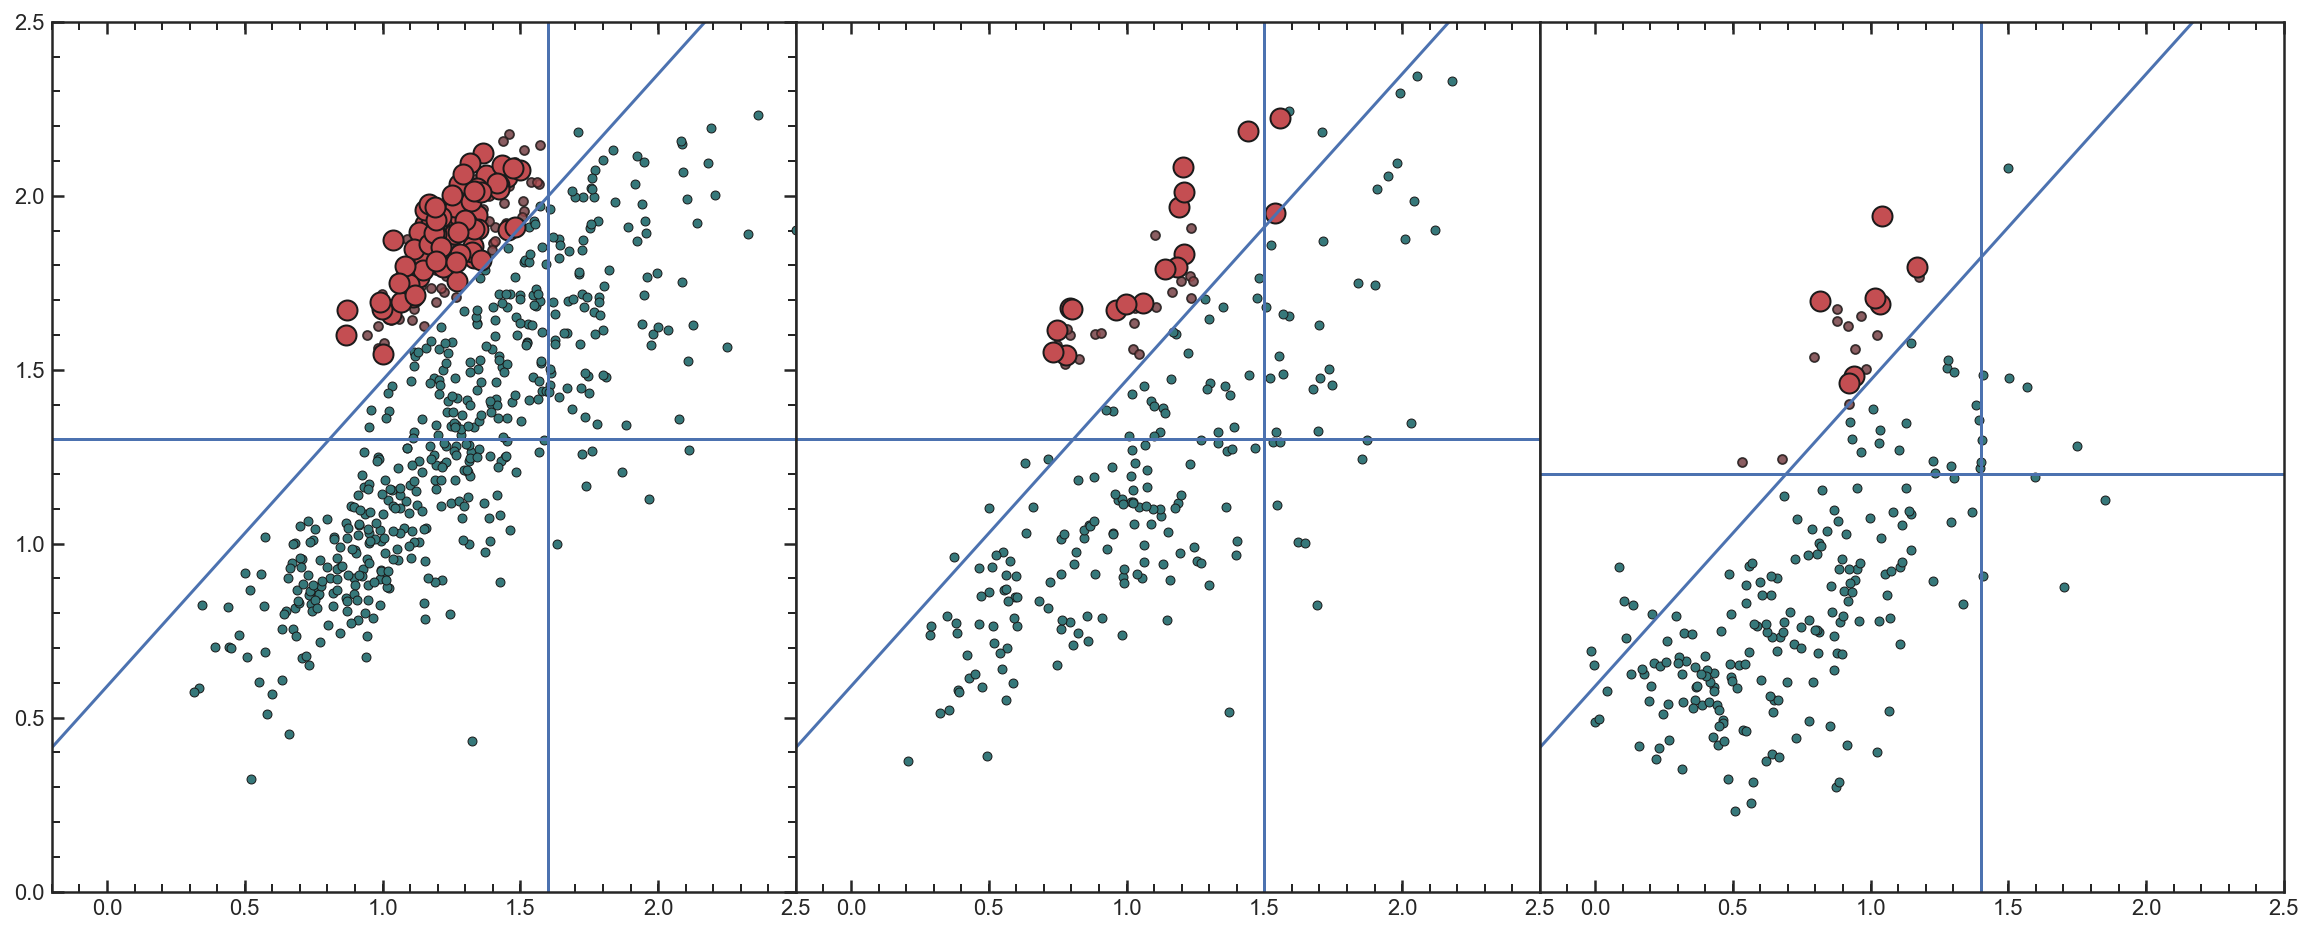

In [19]:
# v4N_red = v4N.query('0.6 < z500 < 3. and star < 0.8 and grism == True and mass > 10**10')
# v4S_red = v4S.query('0.6 < z500 < 3. and star < 0.8 and grism == True and mass > 10**10')


UVJ_W_N = np.array([])
UVJ_W_S = np.array([])

gs = gridspec.GridSpec(1,3, wspace=0)

UVy = np.linspace(0,2.5)
VJx = np.linspace(-1,2.5)

plt.figure(figsize = [20, 8])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1.set_xlim(-0.2,2.5)
ax1.set_ylim(0,2.5)
ax1.axhline(1.3)
ax1.axvline(1.6)
ax1.plot(VJx, 0.88 * VJx +0.59)
NUV, NVJ, SUV, SVJ, NQ, SQ = Whitaker_UVJ_select(0.6, 1.5)
ax1.scatter(SVJ, SUV,marker = 'o', s=20, color = '#36787A',linewidths=0.5, edgecolors='k')
ax1.scatter(NVJ, NUV,marker = 'o', s=20, color = '#36787A',linewidths=0.5, edgecolors='k')
ax1.scatter(SVJ[SQ], SUV[SQ],marker = 'o', s=20, color = 'r',linewidths=1, edgecolors='k', alpha = 0.6)
ax1.scatter(NVJ[NQ], NUV[NQ],marker = 'o', s=20, color = 'r',linewidths=1, edgecolors='k', alpha = 0.6)
ax1.scatter(mdb.query('UVJ == "Q" and 0 < zgrism < 1.5').VJ, mdb.query('UVJ == "Q" and 0 < zgrism < 1.5').UV,marker = 'o', 
            s=100, color = 'r',linewidths=1, edgecolors='k', zorder= 1)
UVJ_W_N = np.append(UVJ_W_N,[v4N.id[U] for U in NQ])
UVJ_W_S = np.append(UVJ_W_S,[v4S.id[U] for U in SQ])

######################################

ax2.set_xlim(-0.2,2.5)
ax2.set_ylim(0,2.5)
ax2.axhline(1.3)
ax2.axvline(1.5)
ax2.set_yticks([])
ax2.plot(VJx, 0.88 * VJx +0.59)
NUV, NVJ, SUV, SVJ, NQ, SQ = Whitaker_UVJ_select(1.5, 2)
ax2.scatter(SVJ, SUV,marker = 'o', s=20, color = '#36787A',linewidths=0.5, edgecolors='k')
ax2.scatter(NVJ, NUV,marker = 'o', s=20, color = '#36787A',linewidths=0.5, edgecolors='k')
ax2.scatter(SVJ[SQ], SUV[SQ],marker = 'o', s=20, color = 'r',linewidths=1, edgecolors='k', alpha = 0.6)
ax2.scatter(NVJ[NQ], NUV[NQ],marker = 'o', s=20, color = 'r',linewidths=1, edgecolors='k', alpha = 0.6)
ax2.scatter(mdb.query('UVJ == "Q" and 1.5 < zgrism < 2.0').VJ, mdb.query('UVJ == "Q" and 1.5 < zgrism < 2.0').UV,marker = 'o', 
            s=100, color = 'r',linewidths=1, edgecolors='k', zorder= 1)
UVJ_W_N = np.append(UVJ_W_N,[v4N.id[U] for U in NQ])
UVJ_W_S = np.append(UVJ_W_S,[v4S.id[U] for U in SQ])
############################################

ax3.set_xlim(-0.2,2.5)
ax3.set_ylim(0,2.5)
ax3.axhline(1.2)
ax3.axvline(1.4)
ax3.set_yticks([])
ax3.plot(VJx, 0.88 * VJx +0.59)
NUV, NVJ, SUV, SVJ, NQ, SQ = Whitaker_UVJ_select(2, 3.0)
ax3.scatter(SVJ, SUV,marker = 'o', s=20, color = '#36787A',linewidths=0.5, edgecolors='k')
ax3.scatter(NVJ, NUV,marker = 'o', s=20, color = '#36787A',linewidths=0.5, edgecolors='k')
ax3.scatter(SVJ[SQ], SUV[SQ],marker = 'o', s=20, color = 'r',linewidths=1, edgecolors='k', alpha = 0.6)
ax3.scatter(NVJ[NQ], NUV[NQ],marker = 'o', s=20, color = 'r',linewidths=1, edgecolors='k', alpha = 0.6)
ax3.scatter(mdb.query('UVJ == "Q" and 2.0 < zgrism < 3.5').VJ, mdb.query('UVJ == "Q" and 2.0 < zgrism < 3.5').UV,marker = 'o', 
            s=100, color = 'r',linewidths=1, edgecolors='k', zorder= 1)
UVJ_W_N = np.append(UVJ_W_N,[v4N.id[U] for U in NQ])
UVJ_W_S = np.append(UVJ_W_S,[v4S.id[U] for U in SQ])

In [6]:
len(UVJ_W_N) + len(UVJ_W_S)

211

In [17]:
for ID in UVJ_W_N:
    if not ID in alldb.query('field == "GND"').id.values:
        print(ID)
print('---')     
for i in mdb.query('field == "GND"').index:
    if not mdb.id[i] in UVJ_W_N:
        print(mdb.id[i])

12006.0
14355.0
17194.0
20538.0
21618.0
22184.0
22633.0
23857.0
26544.0
34130.0
35831.0
37343.0
38126.0
38225.0
14140.0
33777.0
37107.0
12543.0
15976.0
26197.0
38061.0
---
29464
18633
13191
16574
17599
19850
22363
24345
28451
29183
33775
34419
36838
37325
38102


In [18]:
for ID in UVJ_W_S:
    if not ID in alldb.query('field == "GSD"').id.values:
        print(ID)
        
print('---')     
for i in mdb.query('field == "GSD"').index:
    if not mdb.id[i] in UVJ_W_S:
        print(mdb.id[i])

18169.0
20960.0
23102.0
24148.0
24622.0
25053.0
25884.0
26914.0
27965.0
29928.0
30144.0
30152.0
35046.0
35579.0
38472.0
40985.0
42548.0
42985.0
44471.0
46275.0
46500.0
42113.0
43114.0
43683.0
42607.0
44133.0
44725.0
---
24315
24569
37828
39649
41147
42487
42615


In [9]:
GND_all = pd.read_pickle('../dataframes/galaxy_frames/GND_CLEAR.pkl')
GSD_all = pd.read_pickle('../dataframes/galaxy_frames/GSD_CLEAR.pkl')

In [21]:
for ID in UVJ_W_N:
    if not ID in GND_all.id.values:
        print(ID)

14355.0
15901.0
21047.0
21618.0
21683.0
21896.0
22184.0
26544.0
27458.0
27714.0
32566.0
35831.0
37765.0
37955.0
35469.0
37107.0
37189.0
12543.0
22774.0
28890.0


In [22]:
for ID in UVJ_W_S:
    if not ID in GSD_all.id.values:
        print(ID)

18169.0
18642.0
19148.0
20960.0
23102.0
24148.0
24622.0
25053.0
26914.0
26915.0
30144.0
30152.0
32799.0
35046.0
35579.0
37739.0
38472.0
38786.0
44946.0
46500.0
47223.0
48631.0
26139.0
31397.0
35640.0
